## Part 3: Learned shape embeddings

In this notebook, we will learn how to use supervised contrastive learning to create an embedding space for objects described as collections of points.

In [1]:
import os
import h5py
import numpy as np
import random
import tifffile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore') 

from shape_embeddings.data_handling import get_MEF_loader, get_MEF_loaders
from shape_embeddings.model import SpatialTransformer3d, SpatialTransformerkd
from shape_embeddings.utils import Center, RandomCoordsFlip, RandomNoise, show_image, run_logistic_regression, visualize_data

### 0. Data loading and preprocessing

**0.1** The first step needed to train a neural network model is to implement a dataset. A dataset is a class from which data can be sampled for training. This class usually handels most of the data preprocessing including data augmentation. Since we are not focusing on data handling, we already implemented a custom dataset in the lines below.

In [2]:
class MEFDataset(Dataset):
    def __init__(self, dataset, transforms=None):
        super().__init__()
        self.dataset = dataset
        self.base_transform = Center()
        self.transforms = transforms

    def apply_transforms(self, pts):
        for transform in self.transforms:
            pts = transform(pts)
        return pts

    def __getitem__(self, idx):
        label, pts = self.dataset[idx]
        pts = self.base_transform(pts)
        if self.transforms:
            pts = self.apply_transforms(pts)
        return (label, pts.astype(np.float32))

    def __len__(self):
        return len(self.dataset)

**0.2** The next step is to initialize a data loader, such that samples can be drawn during training. The function below first loads the data, partitions it and initializes two MEFDatasets. The datasets are then given data loaders  for training and validation.

*The MEF dataset is presented and prepared in notebook 1 - Data Preparation.*

In [3]:
def get_MEF_loaders(path_to_dataset, batch_size=100, transforms=None):
    # Load data from storage
    mef_data = np.load(path_to_dataset, allow_pickle=True).item()
    data = []
    for key, pts in mef_data.items():
         # we asign label 0 to the wild-type and 1 to the lamin deficient cell
        label = 0 if 'wildtype' in key else 1
        data += [(label, pts.T)]
    random.shuffle(data)
    
    # Split data into training and validation set
    split_index = int(len(data) * 0.75)
    train_data = MEFDataset(data[:split_index], transforms)
    val_data = MEFDataset(data[split_index:])

    train_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)
    return train_loader, val_loader

### 1. The PointNet model

Point clouds are unordered sets of points. We represent them as tensors of shape [num_batches, dim_points, num_points]. The points in such a tensor can be reordered/permuted without changing the structure of the data. This is different from images, in which a reordering of pixels would change the image.

We will use a neural network called PointNet (https://arxiv.org/pdf/1612.00593.pdf) that is specifically designed for point clouds. It accounts for the permutation invariance of the data by processing each point identically and separately in its inital stage. The input to the network are the points in their (x,y) coordinates. The idea is to use a single function to encode each point and then use a pooling operation that summarizes the obtained information. The network learns to select and encode shape informative points. The final pooling and fully connected layers aggregate this information into a global shape descriptor (embedding vector). During training, the embedding vector is further processed using a 'projection head' that compresses the embedding into a lower dimensional space in which the loss is computed. During inference, the embedding vector can be classified by training a linear model.

**1.1** The cell below contains the code for the encoding part of PointNet. The module first applies a learned geometric transformation (e.g. rotation) to the input and then processses each point separately by applying convolutions, batchnorm layers and relu activation. The final max pooling operation aggregates the features into a global vector.

In [4]:
class PointNetEncoder(nn.Module):
    def __init__(self, global_feat=True, feature_transform=False):
        super().__init__()
        self.transformer = SpatialTransformer3d()
        if feature_transform:
            self.feat_transformer = SpatialTransformerkd()

        self.conv1 = nn.Conv1d(2, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

        self.global_feat = global_feat
        self.feat_transform = feature_transform

    def forward(self, x):
        n_pts = x.size()[2]
        trans = self.transformer(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))

        if self.feat_transform:
            trans_feat = self.feat_transformer(x)
            x = x.transpose(2, 1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2, 1)
        else:
            trans_feat = None

        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans, trans_feat
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, n_pts)
            return torch.cat([x, pointfeat], 1), trans, trans_feat

**1.2** The cell below contains the code for PointNet. It first applies the encoder network from the previous cell, followed by two fully connected layers. During training, the obtained embedding vector is further processes with a projection head. The network returns the embedding vector and the projected embedding.

In [5]:
class PointNet(nn.Module):
    def __init__(self,
                 head='mlp',
                 embed_dim=2048,
                 feat_dim=128,
                 feature_transform=False):
        super().__init__()
        self.feature_transform = feature_transform
        self.feat = PointNetEncoder(global_feat=True,
                                    feature_transform=feature_transform)

        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, embed_dim)

        self.bn1 = nn.BatchNorm1d(1024)
        self.relu = nn.ReLU()

        if head == 'linear':
            self.head = nn.Linear(embed_dim, feat_dim)
        elif head == 'mlp':
            self.head = nn.Sequential(
                nn.Linear(embed_dim, embed_dim),
                nn.ReLU(inplace=True),
                nn.Linear(embed_dim, feat_dim)
            )

    def forward(self, x):
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.fc2(x)

        out = F.normalize(self.head(x), dim=1)
        return out, x

### 2. Supervised constrastive loss

**2.1** The idea behind contrastive learning is to pull together an anchor (the sample that is processed) and a 'positive' sample (same class) in embedding space, and push apart the anchor from 'negative' samples (different class). The code in the next cell translates this idea into a supervised contrastive loss function. The inputs to the loss are the ground truth labels and the projected output of the network. The objective itself is a modified normalized temperature-scaled cross entropy loss (see https://arxiv.org/pdf/2004.11362.pdf Eq. 2 & 3 for details).

In [6]:
# Adapted from https://github.com/HobbitLong/SupContrast/blob/master/losses.py
# Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07, contrast_mode='all', base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None):
        batch_size = features.shape[0]
        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T) \
                    .float() \
                    .to(torch.device('cuda' if features.is_cuda else 'cpu'))


        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

### 3. Training

**3.1** The code below contains a simple routine to train our model. In a nutshell, data is fetched from the data loader and given to the model to process. The network outputs a projection and an embedding vector. The projection vector and the labels are given to the loss function to score the prediction. Based on this score, gradients are computed which are used to adjust the weights. 

In [7]:
def train_loop(model, criterion, optimizer, train_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    run_loss = 0.0
    for i, data in enumerate(train_loader):
        labels, points = data
        points = points.to(device)
        labels = labels.to(device)

        # zero parameter gradients
        optimizer.zero_grad()

        # process points with the model
        outputs, embed = model(points)

        # compute loss and gradients
        loss = criterion(outputs.unsqueeze(1), labels)
        loss.backward()

        # optimizer update: adjust network parameters
        optimizer.step()

        # print statistics
        run_loss += loss.item()

    avg_loss = run_loss / len(train_loader)
    return avg_loss

**3.2** In order to assess the performance of our model during training, we use a validation set and a separate routine to score the network. The following code contains a routine that evaluates our model's performance. The first half of the function is similar to the training loop, however we don't compute gradients since we are only interested in the averaged loss on the validation set. In the second half of the function we train a linear model with embedding vectors obtained with our model to classify cells of the validation set. The averaged loss and accuracy of the linear classifier on the validation set are then returned.

In [8]:
def validation_loop(model, criterion, val_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    run_loss = 0.0
    embeddings = []
    labels = []
    for i, data in enumerate(val_loader):
        label, points = data
        points = points.to(device)
        label = label.to(device)
        out, embed = model(points)
        embeddings += [embed.detach().cpu().numpy()]
        labels += [label.cpu().numpy()]
        loss = criterion(out.unsqueeze(1), label)
        run_loss += loss.item()

    # Compute average validation loss
    avg_loss = run_loss / len(val_loader)
    
    # Usa a logistic regression model to evaluate the accuracy
    accuracy = run_logistic_regression(
        np.concatenate(embeddings, axis=0), np.concatenate(labels)
    )

    return accuracy, avg_loss

**3.3** We will use the VMs GPU to train the model more efficiently. Run the lines below make sure that the correct device is selected.

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Selected device: {device}')

Selected device: cpu


**3.4** An important task is to find suitable hyperparameters to train the network. The following cell contains hyperparameters for you to modify. Your task is to find a set of suitable parameters (cell 3.4) and then run cells (3.5 & 3.6) to assess the models performance.

In [10]:
# Set hyperparameters

# Sampler and optimizer parameters
batch_size = 200  # how many samples are given to the network at once
lr = 0.0001  # learning rate
weight_decay = 0.0001  # weight for loss regularization

# Neural network parameters
embedding_dim = 2048  # dimension of the embedding
projection_head = 'mlp' # options ('mlp', 'linear'); Neural network applied to embedding features to compute output features
output_dim = 128  # dimension of the network output
feature_transform = False  # if true, spatial transformer is applied to features

# Loss parameters (they should be fine but you can change them if you want)
temp = 0.07
contrast_mode = 'all'  # options ('all', 'one')
base_temp = 0.07

# Training parameters
epochs = 1  # how many epochs to run the training

**3.5** Run the lines below to initalize all the elements required to train the network.

In [11]:
path_to_data = 'data/MEF_LMNA/mef_data.npy'

# Initialize dataloaders
train_loader, val_loader = get_MEF_loaders(path_to_data, batch_size=batch_size)
                
# Initialize neural network
model = PointNet(head=projection_head,
                embed_dim=embedding_dim,
                feat_dim=output_dim,
                feature_transform=feature_transform).to(device)

# Initialize criterion
criterion = SupConLoss(temperature=temp,
                       contrast_mode=contrast_mode,
                       base_temperature=base_temp)

# Initialize optimizer
optimizer = optim.Adam(model.parameters(),
                       lr=lr,
                       weight_decay=weight_decay)

**3.6** The code below contains the global training routine. Our baseline will be the performance of a model with random weights. We will then train this model for a specified number of epochs. In each epoch the network will iterate once through the whole training set in order to adjust its parameters. After completing one such iteration, the model is evaluated using the validation loop. We will keep track of the best performing parameters, in case the network starts to overfit on the training set.

In [12]:
# Baseline
accuracy, loss = validation_loop(model, criterion, val_loader)
print('Baseline accuracy:  %.3f' % (accuracy))

# Run training
best_accuracy = 0
for epoch in range(epochs):
    loss = train_loop(model, criterion, optimizer, train_loader)
    print('[epoch {}] train loss:  {:.3f}'.format(epoch, loss))
    
    accuracy, val_loss = validation_loop(model, criterion, val_loader)
    print('[epoch {}] val loss / accuracy:  {:.3f} / {:.3f}'.format(epoch, val_loss, accuracy))
    
    if best_accuracy < accuracy:
        best_accuracy = accuracy
        best_params = model.state_dict()

print('Best model accuracy:  {:.3f}'.format(best_accuracy))
model.load_state_dict(best_params)

Baseline accuracy:  0.835
[epoch 0] train loss:  5.276
[epoch 0] val loss / accuracy:  5.246 / 0.822
Best model accuracy:  0.822


<All keys matched successfully>

### 4. Visualize embeddings

In the last part, we will visualize the learned representations and try to identify wild-type/lamin deficient cells using k-means clustering. In order to do that we first process the whole dataset with the trained model and map each cell to its corresponding embedding.

**4.1** Process the whole dataset using the trained model from the previous section. The output should be a tensor of shape [number of cells in the dataset, embedding dimension] that contains the embeddings and a tensor of shape [number of cells in the dataset] with the corresponding labels. Hint: have another look at the 'validation_loop' function in (3.2).

In [13]:
loader = get_MEF_loader('data/MEF_LMNA/mef_data.npy')
model.eval()

# Solution:
embeddings = []
labels = []
for data in loader:
    label, points = data
    points = points.to(device)
    out, embed = model(points)
    embeddings += [embed.detach().cpu().numpy()]
    labels += [label]
    
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels)

**4.2** Apply principal component analysis (PCA) to the embeddings and visualize it by projecting onto the first two principal components. Use labels to assign colors to the points.

In [14]:
from sklearn.decomposition import PCA

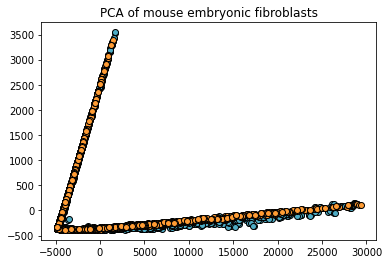

In [15]:
# Solution:
pca = PCA(n_components=2)
X_r = pca.fit(embeddings).transform(embeddings)

colors = ['#4EACC5', '#FF9C34']
plt.figure()
plt.title('PCA of mouse embryonic fibroblasts')
for color, i, target_name in zip(colors, [0, 1], ['wild-type', 'lmna']):
    plt.scatter(X_r[labels == i, 0], X_r[labels == i, 1],
                color=color, label=target_name, edgecolor='k')

**4.3** Apply k-means clustering to the embeddings and compare with the correct labels how it clusters.

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

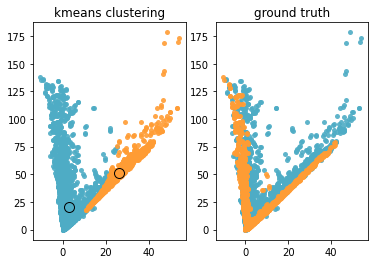

In [17]:
# Solution:
kmeans = KMeans(n_clusters=2)
kmeans.fit(embeddings)
kmeans_labels = pairwise_distances_argmin(embeddings, kmeans.cluster_centers_)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.set_title('kmeans clustering')
for k, col in zip(range(2), colors):
    cluster_center = kmeans.cluster_centers_[k]
    plt.plot(embeddings[kmeans_labels == k, 0], embeddings[kmeans_labels == k, 1],
             'o' , markerfacecolor=col, marker='.', markersize=10, markeredgecolor='none', alpha=0.9)
    plt.plot(cluster_center[0], cluster_center[1],
             'o', markerfacecolor=col, markeredgecolor='k', markersize=10)
ax = fig.add_subplot(1, 2, 2)
ax.set_title('ground truth')
for k, col in zip(range(2), colors):
    cluster_center = kmeans.cluster_centers_[k]
    plt.plot(embeddings[labels == k, 0], embeddings[labels == k, 1],
             'o' , markerfacecolor=col, marker='.', markersize=10, markeredgecolor='none', alpha=0.9)
plt.show()